In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score
import math, time

# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 5
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [84]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts image to [1, 28, 28] and scales to [0, 1]
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=BATCH_SIZE)


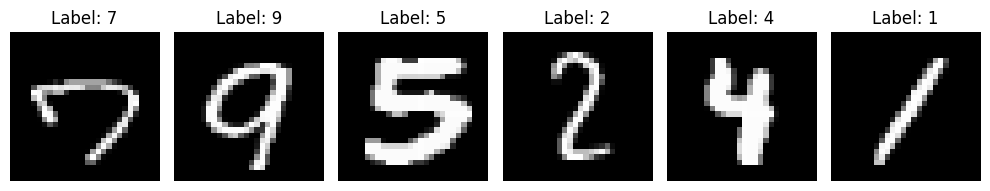

In [85]:
import matplotlib.pyplot as plt

# Get a few sample images and labels
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

# Show first 6 images in the batch
plt.figure(figsize=(10, 3))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(example_data[i][0], cmap='gray')
    plt.title(f"Label: {example_targets[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [86]:
print("Image batch shape:", example_data.shape)   # [64, 1, 28, 28]
print("Label batch shape:", example_targets.shape)  # [64]

print("Number of training images:", len(train_data))
print("Number of test images:", len(test_data))


Image batch shape: torch.Size([64, 1, 28, 28])
Label batch shape: torch.Size([64])
Number of training images: 60000
Number of test images: 10000


In [87]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)


In [88]:
class MNISTTransformer(nn.Module):
    def __init__(self, input_dim=28, model_dim=128, num_heads=4, num_layers=2, num_classes=10):
        super().__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        self.pos_enc = PositionalEncoding(model_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dim_feedforward=256,  batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Linear(model_dim, num_classes)

    def forward(self, x):
        x = x.squeeze(1)              # (B, 28, 28)
        x = self.embedding(x)         # (B, 28, model_dim)
        x = self.pos_enc(x)           # (B, 28, model_dim)
        x = x.permute(1, 0, 2)        # (28, B, model_dim)
        x = self.transformer(x)       # (28, B, model_dim)
        x = x.mean(dim=0)             # (B, model_dim)
        return self.classifier(x)     # (B, 10)


In [ ]:
class MNISTTransformer(nn.Module):
    def __init__(self, input_dim=28, model_dim=128, num_heads=4, num_layers=2, num_classes=10):
        super().__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        self.pos_enc = PositionalEncoding(model_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dim_feedforward=256,  batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Linear(model_dim, num_classes)

    def forward(self, x):
        x = x.squeeze(1)              # (B, 28, 28)
        x = self.embedding(x)         # (B, 28, model_dim)
        x = self.pos_enc(x)           # (B, 28, model_dim)
        x = x.permute(1, 0, 2)        # (28, B, model_dim)
        x = self.transformer(x)       # (28, B, model_dim)
        x = x.mean(dim=0)             # (B, model_dim)
        return self.classifier(x)     # (B, 10)


In [89]:
model = MNISTTransformer().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()


In [90]:
def train():
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()


In [91]:
def evaluate():
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')

    print(f"Accuracy:  {acc * 100:.2f}%")
    print(f"F1 Score:  {f1:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"Precision: {precision:.4f}")


In [92]:
import time

total_start = time.time()  # ⏱ Start total training timer

for epoch in range(EPOCHS):
    start = time.time()  # ⏱ Start epoch timer

    train()  # Train for one epoch

    duration = time.time() - start  # Time taken for this epoch
    print(f"\nEpoch {epoch+1} completed in {duration:.2f} seconds:")

    evaluate()  # Evaluate after each epoch if needed

total_duration = time.time() - total_start  # Total time for all epochs
print(f"\n✅ Training completed in {total_duration:.2f} seconds.")




Epoch 1 completed in 80.16 seconds:
Accuracy:  92.87%
F1 Score:  0.9291
Recall:    0.9287
Precision: 0.9322

Epoch 2 completed in 81.71 seconds:
Accuracy:  95.32%
F1 Score:  0.9531
Recall:    0.9532
Precision: 0.9536

Epoch 3 completed in 77.97 seconds:
Accuracy:  95.30%
F1 Score:  0.9530
Recall:    0.9530
Precision: 0.9538

Epoch 4 completed in 79.41 seconds:
Accuracy:  95.97%
F1 Score:  0.9597
Recall:    0.9597
Precision: 0.9599

Epoch 5 completed in 77.12 seconds:
Accuracy:  96.19%
F1 Score:  0.9619
Recall:    0.9619
Precision: 0.9620

✅ Training completed in 417.95 seconds.


In [93]:
# defining function to count parameters
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal trainable parameters: {total:,}\n")
    
    print(f"{'Layer':<60} {'Param #':>12}")
    print("="*75)
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name:<60} {param.numel():>12}")


In [94]:
model = MNISTTransformer().to(DEVICE)
count_parameters(model)



Total trainable parameters: 269,962

Layer                                                             Param #
embedding.weight                                                     3584
embedding.bias                                                        128
transformer.layers.0.self_attn.in_proj_weight                       49152
transformer.layers.0.self_attn.in_proj_bias                           384
transformer.layers.0.self_attn.out_proj.weight                      16384
transformer.layers.0.self_attn.out_proj.bias                          128
transformer.layers.0.linear1.weight                                 32768
transformer.layers.0.linear1.bias                                     256
transformer.layers.0.linear2.weight                                 32768
transformer.layers.0.linear2.bias                                     128
transformer.layers.0.norm1.weight                                     128
transformer.layers.0.norm1.bias                                       128


In [102]:
torch.save(model.state_dict(), "full_precision.pth")
state_dict = torch.load("full_precision.pth")


In [103]:
for name in state_dict:
    print(name)


embedding.weight
embedding.bias
transformer.layers.0.self_attn.in_proj_weight
transformer.layers.0.self_attn.in_proj_bias
transformer.layers.0.self_attn.out_proj.weight
transformer.layers.0.self_attn.out_proj.bias
transformer.layers.0.linear1.weight
transformer.layers.0.linear1.bias
transformer.layers.0.linear2.weight
transformer.layers.0.linear2.bias
transformer.layers.0.norm1.weight
transformer.layers.0.norm1.bias
transformer.layers.0.norm2.weight
transformer.layers.0.norm2.bias
transformer.layers.1.self_attn.in_proj_weight
transformer.layers.1.self_attn.in_proj_bias
transformer.layers.1.self_attn.out_proj.weight
transformer.layers.1.self_attn.out_proj.bias
transformer.layers.1.linear1.weight
transformer.layers.1.linear1.bias
transformer.layers.1.linear2.weight
transformer.layers.1.linear2.bias
transformer.layers.1.norm1.weight
transformer.layers.1.norm1.bias
transformer.layers.1.norm2.weight
transformer.layers.1.norm2.bias
classifier.weight
classifier.bias


In [104]:
for name, param in state_dict.items():
    print(f"Layer: {name}")
    print(f"Shape: {list(param.shape)}")
    print(f"Values:\n{param}\n")
    print("=" * 60)


Layer: embedding.weight
Shape: [128, 28]
Values:
tensor([[ 0.0829,  0.0953, -0.0074,  ..., -0.1192, -0.1312,  0.1086],
        [ 0.0645,  0.0582, -0.0803,  ..., -0.1500,  0.0287,  0.0968],
        [ 0.0590,  0.0028,  0.0488,  ...,  0.0785,  0.0548,  0.1621],
        ...,
        [ 0.1346,  0.0248, -0.0265,  ..., -0.0672,  0.1621,  0.1520],
        [ 0.1193,  0.0423, -0.1733,  ..., -0.0471,  0.1729,  0.0353],
        [-0.0630,  0.1092, -0.1341,  ...,  0.1453,  0.0914,  0.1046]])

Layer: embedding.bias
Shape: [128]
Values:
tensor([-0.0326,  0.1110, -0.0937, -0.0464, -0.0322, -0.1682,  0.1825,  0.0523,
        -0.1390,  0.0024, -0.1347,  0.1498, -0.1115, -0.1518,  0.1580, -0.1645,
         0.1185, -0.1095, -0.1103,  0.1026,  0.0411, -0.0851,  0.1397, -0.0670,
        -0.0605,  0.1278, -0.1706, -0.0491, -0.1318,  0.1542,  0.1217, -0.0843,
         0.0858, -0.1206, -0.1659, -0.0159, -0.0402, -0.1030, -0.0226, -0.1466,
        -0.1722, -0.0865, -0.1115, -0.1684, -0.0863,  0.1097, -0.0349,  0

In [105]:
with open("full_precision_parameters.txt", "w") as f:
    for name, param in state_dict.items():
        f.write(f"Layer: {name}\n")
        f.write(f"Shape: {list(param.shape)}\n")
        f.write(f"Values:\n{param.cpu().numpy()}\n")
        f.write("=" * 60 + "\n")


In [99]:
print(model)


MNISTTransformer(
  (embedding): Linear(in_features=28, out_features=128, bias=True)
  (pos_enc): PositionalEncoding()
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=128, out_features=10, bias=True)
)


In [100]:
for name, param in model.named_parameters():
    print(f"{name:40s} | dtype: {param.dtype}")


embedding.weight                         | dtype: torch.float32
embedding.bias                           | dtype: torch.float32
transformer.layers.0.self_attn.in_proj_weight | dtype: torch.float32
transformer.layers.0.self_attn.in_proj_bias | dtype: torch.float32
transformer.layers.0.self_attn.out_proj.weight | dtype: torch.float32
transformer.layers.0.self_attn.out_proj.bias | dtype: torch.float32
transformer.layers.0.linear1.weight      | dtype: torch.float32
transformer.layers.0.linear1.bias        | dtype: torch.float32
transformer.layers.0.linear2.weight      | dtype: torch.float32
transformer.layers.0.linear2.bias        | dtype: torch.float32
transformer.layers.0.norm1.weight        | dtype: torch.float32
transformer.layers.0.norm1.bias          | dtype: torch.float32
transformer.layers.0.norm2.weight        | dtype: torch.float32
transformer.layers.0.norm2.bias          | dtype: torch.float32
transformer.layers.1.self_attn.in_proj_weight | dtype: torch.float32
transformer.layer

In [ ]:
hi